# Loading Biobank Data

In [1]:
import pandas as pd
import numpy as np
import pyreadr
import torch

In [2]:
biobank_outcomes = 'biobank/outcome_definition/Outputs/'

### Reading AF data

In [3]:
AF = pyreadr.read_r(biobank_outcomes + 'AF/output_final.rds')[None]
AF.shape

(502401, 10)

In [4]:
# Commented for data confidentiality
# AF.head()

In [5]:
AF_prev = AF.loc[AF['prevalent_case'] == 1][['eid', 'date_recr']]
AF_prev.shape

(7608, 2)

In [6]:
# Only select those on anticoagulants (ie., warfarin at the time of the study)
warfarin = pyreadr.read_r(biobank_outcomes + 'Anticoags/output_final.rds')[None][['eid', 'prevalent_case']]
warfarin = warfarin[warfarin['prevalent_case'] == 1]
warfarin = warfarin['eid']
warfarin.shape

(5328,)

### Merging predictors

In [7]:
biobank = pyreadr.read_r('biobank/extraction_and_recoding/outputs.af/ukb_extracted.rds')[None]

cols_to_drop = [col for col in biobank.columns if col.startswith('med_vitamin_')]

biobank = biobank.drop(cols_to_drop, axis=1)

# Commented for data confidentiality
# biobank

In [8]:
files_mapping = {
    'antiplatelets': 'Antiplatelets',
    'benzos': 'Benzos',
    'nsaids': 'NSAIDs',
    'ocs': 'OCS',
    'ppi': 'PPI',
    'ssri': 'SSRI',
    'stjohns': 'StJohns',
    'chf': 'CHF',
    'copd': 'COPD',
    'htn': 'HTN',
    'liverdis': 'LiverDis',
    'anaemia': 'Anaemia',
    'cancer': 'Cancer',
    't2dm': 'T2DM',
    'vte': 'Thromboembolism',
    'vascdis': 'VascularDisease'
}

df_list = []

for var_name, file_name in files_mapping.items():
    df = pyreadr.read_r(biobank_outcomes + file_name + '/output_final.rds')[None]['prevalent_case'].rename(var_name)
    df_list.append(df)

majbleed = pyreadr.read_r(biobank_outcomes + 'MajBleed/output_final.rds')[None][['eid', 'prevalent_case', 'incident_case', 'time_to_diagnosis_incident', 'date_diagnosis_incident']].rename(columns={'prevalent_case': 'majbleed_prev', 'incident_case': 'out_majbleed_inc', 'time_to_diagnosis_incident': 'out_maj_bleed_inc_timeto'})
majbleed['out_majbleed_inc'] = majbleed['out_maj_bleed_inc_timeto'].apply(lambda x: 1 if pd.notna(x) else 0)
df_list.append(majbleed)

merged_df = pd.concat(df_list, axis = 1)

merged_df = pd.concat([biobank.reset_index(), merged_df.reset_index()], axis = 1)

In [9]:
merged_df['out_majbleed_inc'].value_counts()

0    440801
1     61600
Name: out_majbleed_inc, dtype: int64

### Merging with Biobank features

In [10]:
merged_df = pd.DataFrame(warfarin).merge(merged_df, on='eid', how='inner')

In [11]:
merged_df = merged_df.drop('index', axis=1).reset_index()

In [12]:
merged_df['out_majbleed_inc'].value_counts()

0    3862
1    1466
Name: out_majbleed_inc, dtype: int64

# Pre-processing

### Cleaning data

In [13]:
quali_cols = [col for col in merged_df.columns if col.startswith("se_quali")]

quali_dict = {
    "1": "ColUni",
    "2": "ALevels",
    "3": "OLevels",
    "4": "CSEs",
    "5": "NVQ",
    "6": "Other",
    "-7": "None",
    "-3": "Prefer not to answer"
}

# Update the order of qualifications by assigning a numeric value to each qualification type
quali_order = {
    "1": 7,  # ColUni
    "2": 4,  # ALevels
    "3": 3,  # OLevels
    "4": 2,  # CSEs
    "5": 6,  # NVQ
    "6": 5,  # Other
    "-7": 1,  # None
    "-3": 0   # Prefer not to answer
}

def highest_qualification(row):
    highest_quali = np.NaN
    highest_value = 0
    
    for quali_col in quali_cols:
        field = row[quali_col]
        if pd.notna(field):
            field = str(int(field))
            if field in quali_order:
                value = quali_order[field]
                if value > highest_value:
                    highest_value = value
                    highest_quali = field
                
    return highest_quali

merged_df['se_highest_quali'] = merged_df.apply(highest_qualification, axis=1)

In [14]:
cols_to_drop = [col for col in merged_df.columns if col.startswith('se_quali')]

merged_df = merged_df.drop(cols_to_drop, axis=1)

In [15]:
merged_df.columns

Index(['index', 'eid', 'be_alcohol_freq.0.0', 'be_physact_mod.0.0',
       'be_physact_vig.0.0', 'be_physact_walks.0.0', 'be_smok_packyears.0.0',
       'be_smok_status.0.0', 'bio_alb.0.0', 'bio_alp.0.0', 'bio_alt.0.0',
       'bio_ast.0.0', 'bio_bas.0.0', 'bio_chol.0.0', 'bio_cr.0.0',
       'bio_eos.0.0', 'bio_ggt.0.0', 'bio_hb.0.0', 'bio_hba1c.0.0',
       'bio_hct.0.0', 'bio_lymph.0.0', 'bio_mon.0.0', 'bio_neutr.0.0',
       'bio_plt.0.0', 'bio_ret.0.0', 'bio_tg.0.0', 'bio_urate.0.0',
       'bio_urea.0.0', 'bio_vitd.0.0', 'bl_age.0.0', 'bl_ethnicity.0.0',
       'bl_sex.0.0', 'bmi.0.0', 'bp_dia.0.0', 'bp_dia.0.1', 'bp_sys.0.0',
       'bp_sys.0.1', 'comorb_cancer_icd10.0.0', 'comorb_cancer_icd9.0.0',
       'comorb_falls_lastyear.0.0', 'comorb_miscarriage.0.0', 'se_depr.0.0',
       'bl_datelost.0.0', 'rownames', 'antiplatelets', 'benzos', 'nsaids',
       'ocs', 'ppi', 'ssri', 'stjohns', 'chf', 'copd', 'htn', 'liverdis',
       'anaemia', 'cancer', 't2dm', 'vte', 'vascdis', 'majb

### Remapping per Biobank Dictionary

In [16]:
backup_df = merged_df

In [17]:
import numpy as np

merged_df['be_smok_packyears.0.0'] = np.where(merged_df['be_smok_status.0.0'] == 0, 0, merged_df['be_smok_packyears.0.0'])
merged_df.loc[merged_df['be_smok_status.0.0'] == -3, 'be_smok_status.0.0'] = np.NaN
merged_df.loc[merged_df['be_alcohol_freq.0.0'] == -3, 'be_alcohol_freq.0.0'] = np.NaN
merged_df.loc[(merged_df['bl_ethnicity.0.0'] == -1) | (merged_df['bl_ethnicity.0.0'] == -3), 'bl_ethnicity.0.0'] = np.NaN
merged_df.loc[(merged_df['be_physact_walks.0.0'] == -1) | (merged_df['be_physact_walks.0.0'] == -3), 'be_physact_walks.0.0'] = np.NaN
merged_df.loc[merged_df['be_physact_walks.0.0'] == -2, 'be_physact_walks.0.0'] = 0
merged_df.loc[(merged_df['be_physact_mod.0.0'] == -1) | (merged_df['be_physact_mod.0.0'] == -3), 'be_physact_mod.0.0'] = np.NaN
merged_df.loc[(merged_df['be_physact_vig.0.0'] == -1) | (merged_df['be_physact_vig.0.0'] == -3), 'be_physact_vig.0.0'] = np.NaN


### Checking missingness

In [18]:
import matplotlib.pyplot as plt

# Count missing values
col_missing = (merged_df.isnull().sum(axis=0)/merged_df.shape[0])*100
pd.options.display.max_rows = 100

print(col_missing)

index                         0.000000
eid                           0.000000
be_alcohol_freq.0.0           0.300300
be_physact_mod.0.0           33.840090
be_physact_vig.0.0           95.326577
be_physact_walks.0.0         19.256757
be_smok_packyears.0.0        17.830330
be_smok_status.0.0            0.919670
bio_alb.0.0                  15.277778
bio_alp.0.0                   7.826577
bio_alt.0.0                   7.882883
bio_ast.0.0                   8.389640
bio_bas.0.0                   5.874625
bio_chol.0.0                  7.807808
bio_cr.0.0                    7.901652
bio_eos.0.0                   5.874625
bio_ggt.0.0                   7.845345
bio_hb.0.0                    5.686937
bio_hba1c.0.0                 7.225976
bio_hct.0.0                   5.686937
bio_lymph.0.0                 5.874625
bio_mon.0.0                   5.874625
bio_neutr.0.0                 5.874625
bio_plt.0.0                   5.686937
bio_ret.0.0                   7.376126
bio_tg.0.0               

### Imputation (with missForest)

In [19]:
# Dropping vars with large missingness
to_impute = merged_df.drop(['index', 'eid', 'be_physact_mod.0.0', 'be_physact_vig.0.0',#'date_recr', 
                           'comorb_cancer_icd10.0.0', 'comorb_cancer_icd9.0.0', 'comorb_miscarriage.0.0',
                           'out_majbleed_inc', 'out_maj_bleed_inc_timeto', 'date_diagnosis_incident', 'bl_datelost.0.0', 'rownames'], axis=1)

cols_to_numeric = ['bl_age.0.0', 'comorb_falls_lastyear.0.0', 'bp_dia.0.0', 'bp_dia.0.1', 'bp_sys.0.0', 'bp_sys.0.1']

for col in cols_to_numeric:
    to_impute[col] = pd.to_numeric(to_impute[col])

# Use mean blood pressure of the two readings
to_impute['bp_sys_avg'] = to_impute[['bp_sys.0.0', 'bp_sys.0.1']].mean(axis=1)
to_impute['bp_dia_avg'] = to_impute[['bp_dia.0.0', 'bp_dia.0.1']].mean(axis=1)

to_impute = to_impute.drop(['bp_dia.0.0', 'bp_dia.0.1', 'bp_sys.0.0', 'bp_sys.0.1'], axis=1)

cols_to_convert = [
    'bl_sex.0.0', 'antiplatelets', 'benzos', 'nsaids', 'ocs', 'ppi', 'ssri', 'stjohns', 'chf',
    'copd', 'htn', 'liverdis', 'anaemia', 'cancer', 'vte', 't2dm', 'vascdis', 'majbleed_prev'
]

for col in cols_to_convert:
    to_impute[col] = to_impute[col].astype('category')

In [20]:
# Grouping ethnicity values

ethnicity_map = {
    1: 'White',
    1001: 'White',
    2001: 'Mixed',
    3001: 'Asian or Asian British',
    4001: 'Black or Black British',
    2: 'Mixed',
    1002: 'White',
    2002: 'Mixed',
    3002: 'Asian or Asian British',
    4002: 'Black or Black British',
    3: 'Asian or Asian British',
    1003: 'White',
    2003: 'Mixed',
    3003: 'Asian or Asian British',
    4003: 'Black or Black British',
    4: 'Black or Black British',
    2004: 'Mixed',
    3004: 'Asian or Asian British',
    5: 'Asian or Asian British',
    6: 'Other ethnic group',
    -1: 'Do not know',
    -3: 'Prefer not to answer'
}

to_impute['bl_ethnicity.0.0'] = to_impute['bl_ethnicity.0.0'].map(ethnicity_map)

In [21]:
# Deriving typical years in education, per the literature
to_impute['se_highest_quali'] = to_impute['se_highest_quali'].astype(float).map({
    1: 7,
    2: 4,
    3: 3,
    4: 2,
    5: 6,
    6: 5,
    -7: 1
})

# Averaging alcohol intake according to survey question
to_impute['be_alcohol_freq.0.0'] = to_impute['be_alcohol_freq.0.0'].map({
    1: 6,
    2: 3.5,
    3: 1.5,
    4: 0.5,
    5: 0.15,
    6: 0,
    -7: np.NaN
})

In [22]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# One-hot encoding
categorical_columns = ['bl_ethnicity.0.0', 'be_smok_status.0.0']

# Encode the categorical columns
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(to_impute[categorical_columns])

# Setting NA for missing values (per 'missing' column)
encoded_columns[np.isnan(encoded_columns[:, 5]), 0:5] = np.nan
encoded_columns[np.isnan(encoded_columns[:, 9]), 6:9] = np.nan

encoded_columns = np.delete(encoded_columns, [5, 9], axis=1)

# Merge the encoded columns with the rest of the dataset
to_impute_ = pd.concat([to_impute.drop(categorical_columns, axis=1),
               pd.DataFrame(encoded_columns)], axis=1)

In [23]:
for col in to_impute_.columns:
    to_impute_[col] = pd.to_numeric(to_impute_[col], errors='coerce')

In [24]:
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
import warnings

# Ignore FutureWarnings from sklearn
warnings.simplefilter(action='ignore', category=Warning)

# Make an instance and perform the imputation
imputer = MissForest(random_state=42)
X = to_impute_
X_imputed = imputer.fit_transform(X, cat_vars=[25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 49, 50, 51, 52, 53, 54, 55, 56])

warnings.resetwarnings()

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


In [25]:
X_imputed_df_onehot = pd.DataFrame(X_imputed)
X_imputed_df_onehot.columns = X.columns

In [26]:
X_imputed_df_onehot = X_imputed_df_onehot.rename(columns={0: "ethnicity.asian", 
                                                          1: "ethnicity.black",
                                                          2: "ethnicity.mixed",
                                                          3: "ethnicity.other",
                                                          4: "ethnicity.white",
                                                          5: "smoking.never",
                                                          6: "smoking.previous",
                                                          7: "smoking.current"})

In [27]:
selected_columns = merged_df[['out_majbleed_inc', 'out_maj_bleed_inc_timeto']]
XY_imputed_onehot = pd.concat([X_imputed_df_onehot, selected_columns], axis=1)

In [28]:
XY_imputed_onehot['out_bled_in_2yr'] = XY_imputed_onehot['out_maj_bleed_inc_timeto'].apply(lambda x: 1 if x < 1860 else 0)

In [29]:
XY_imputed_onehot['out_bled_in_2yr'].value_counts()

0    4634
1     694
Name: out_bled_in_2yr, dtype: int64

# Calculating ORBIT-AF score

In [30]:
from sklearn.model_selection import train_test_split

# Creating training / test split
X_hot = XY_imputed_onehot.drop(['out_bled_in_2yr', 'out_majbleed_inc', 'out_maj_bleed_inc_timeto'], axis=1)
y_hot = XY_imputed_onehot['out_bled_in_2yr'] #out_bled_in_2yr #out_majbleed_inc
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(X_hot, y_hot, test_size=0.2, random_state=42, stratify=y_hot)


In [31]:
scores = []
#result_trunc = result.head(20)

for _, person in X_hot.iterrows():
    score = 0
    if person['bl_age.0.0'] > 74:
        score += 1
    if person['majbleed_prev'] == 1 or person['anaemia'] == 1:
        score += 2
    if person['antiplatelets'] == 1:
        score += 1 
    
    sex_fem = person['bl_sex.0.0'] == 0
    age = person['bl_age.0.0']
    black = person['ethnicity.black'] == 1
    cr = person['bio_cr.0.0']
    egfr = 175 * ((cr * 0.011312)**(-1.154)) * (age**(-0.203))
    egfr *= 0.742 if sex_fem else 1
    egfr *= 1.212 if black else 1
    
    score += 1 if egfr < 60 else 0
    
    hb = person['bio_hb.0.0']
    hct = person['bio_hct.0.0']
    
    if sex_fem:
        score += 2 if (hb < 12 or hct < 36) else 0
    else:
        score += 2 if (hb < 13 or hct < 40) else 0
        
    scores.append(score)

X_hot['score'] = scores

In [32]:
y_hot = y_hot.rename('out_bled_in_2yr')

summary_table = pd.concat([X_hot, y_hot], axis=1).groupby(['score', 'out_bled_in_2yr']).size().reset_index(name='count')
summary_table_pivot = summary_table.pivot_table(index='score', columns='out_bled_in_2yr', values='count', fill_value=0)
summary_table_pivot.reset_index(inplace=True)

print(summary_table_pivot)

out_bled_in_2yr  score     0    1
0                    0  2812  305
1                    1   478   82
2                    2   908  167
3                    3   239   68
4                    4   143   44
5                    5    47   23
6                    6     7    5


In [33]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(pd.DataFrame(y_hot), X_hot['score']) #out_bled_in_2yr # out_majbleed_inc

print(f"The c-statistic (AUC) is: {auc}")

The c-statistic (AUC) is: 0.5986503092665538


# Machine Learning Models

In [34]:
from imblearn.under_sampling import RandomUnderSampler


In [35]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Merge the encoded columns with the rest of the dataset
X = XY_imputed_onehot.drop(['out_bled_in_2yr', 'out_majbleed_inc', 'out_maj_bleed_inc_timeto'], axis=1)
y = XY_imputed_onehot['out_bled_in_2yr'] #out_bled_in_2yr #out_majbleed_inc

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [38]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## RandomForest

### Hyperparameter Tuning

In [39]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
from scipy.stats import randint

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(sampling_strategy=0.5, random_state = 42)
under = RandomUnderSampler(sampling_strategy=1, random_state = 42)

steps = [('smote', smote),
         ('under', under),
         ('model', RandomForestClassifier(random_state = 42))]#))]
pipeline = Pipeline(steps=steps)

parameters = {'model__max_features':['sqrt','log2'], 'model__n_estimators':[1000],
              'model__max_depth':range(12,28,2),'model__min_samples_leaf':[1,2,4], 
              'model__min_samples_split':range(4,22,2),
              'model__criterion' :['gini', 'entropy']}

# 200 repeats (as with NN) probably not necessary - results are quite stable.
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=20, random_state=42) #changed

rf_class = GridSearchCV(estimator=pipeline, param_grid=parameters, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=1)#, return_train_score=True,

rf_class.fit(X=X_train, y=y_train)
rf_model = rf_class.best_estimator_

print('The best parameters are {}'.format(rf_class.best_params_))

Fitting 100 folds for each of 864 candidates, totalling 86400 fits
The best parameters are {'model__criterion': 'gini', 'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 1, 'model__min_samples_split': 14, 'model__n_estimators': 1000}


### Fitting and Calibration

In [43]:
from sklearn.calibration import CalibratedClassifierCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_smote, y_train_smote = SMOTE(sampling_strategy=0.5, random_state=42).fit_resample(X_train, y_train)
X_train_smoteund, y_train_smoteund = RandomUnderSampler(sampling_strategy=1, random_state=42).fit_resample(X_train_smote, y_train_smote)

clf = RandomForestClassifier(random_state=42, criterion='gini', max_features='sqrt', min_samples_split=14, min_samples_leaf=1, max_depth = 20, n_estimators = 2000)

clf.fit(X_train_smoteund, y_train_smoteund)

clf_isotonic = CalibratedClassifierCV(clf, method='isotonic', cv=5, ensemble=True)
clf_isotonic.fit(X_train_smoteund, y_train_smoteund)
predictions_isotonic = clf_isotonic.predict_proba(X_test)

y_pred = clf_isotonic.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred)))

# Calculate AUC
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print(f"AUC (Uncalibrated): {auc:.4f}")

auc = roc_auc_score(y_test, clf_isotonic.predict_proba(X_test)[:,1])
print(f"AUC (Calibrated): {auc:.4f}")

Accuracy: 0.86
Precision: 0.22
Recall: 0.04
F1 Score: 0.07
AUC (Uncalibrated): 0.6369
AUC (Calibrated): 0.6352


### Shapley Values

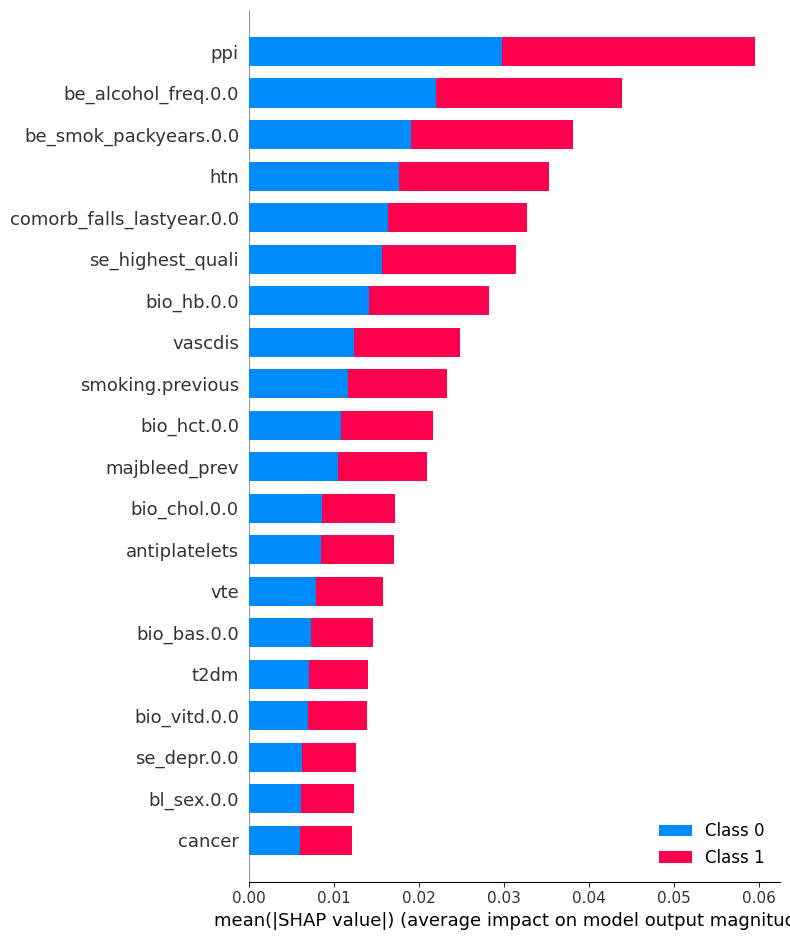

In [264]:
import shap
shap_values = shap.TreeExplainer(clf).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


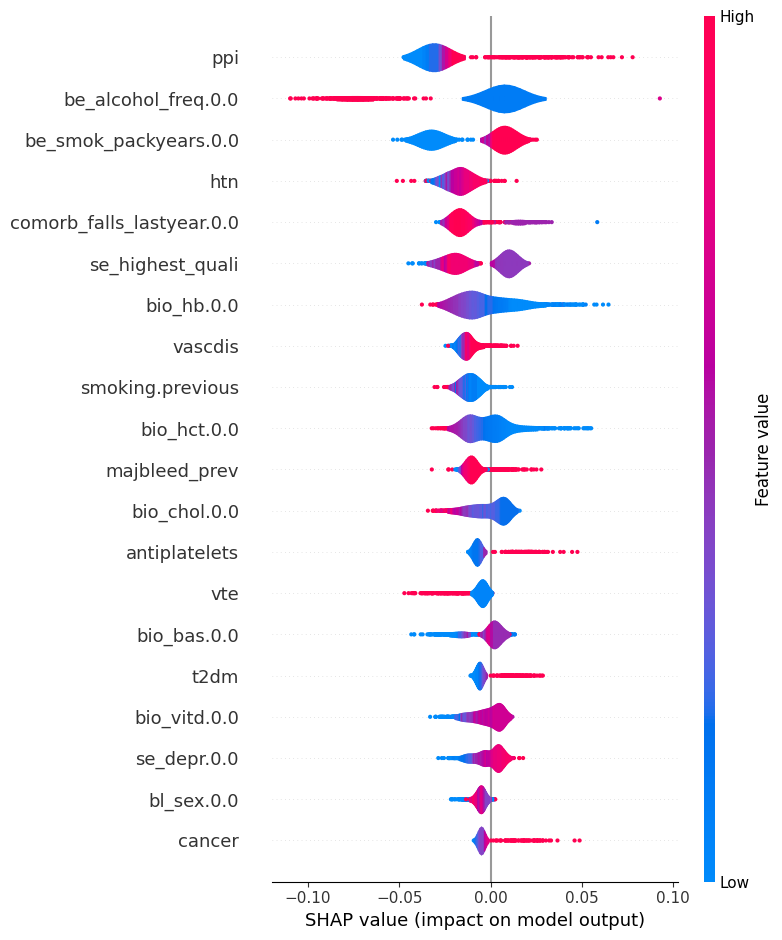

In [267]:
shap.summary_plot(shap_values[1], X_test, plot_type="violin")

## Neural Network

### Hyperparameter Tuning

Note: Hyperparameter tuning performed separately, see included files.

### Fitting

In [45]:
# Neural network architecture with dropout
import torch.nn as nn
from skorch import NeuralNetBinaryClassifier, NeuralNetClassifier
import torch.optim as optim
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from imblearn.pipeline import Pipeline
from skorch.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.model_selection import cross_validate


torch.manual_seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class NeuralNet(nn.Module):
    def __init__(
        self, dropout_prob=0.2, n_neurons1=16, n_neurons2=16, weight_constraint=1.0
    ):
        super(NeuralNet, self).__init__()
        self.layer1 = nn.Linear(input_size, n_neurons1)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.layer2 = nn.Linear(n_neurons1, n_neurons2)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.layer3 = nn.Linear(n_neurons2, 1)
        self.weight_constraint = weight_constraint

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = self.layer3(x)
        return x

input_size = X_train.shape[1]
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)

def tofloat32(x):
    return torch.tensor(x, dtype=torch.float32).to("cpu")

model = NeuralNetBinaryClassifier(
    NeuralNet,
    criterion=nn.BCEWithLogitsLoss,
    # max_epochs=150,
    # batch_size=32,
    max_epochs=500,
    batch_size=32,
    verbose=False,
    optimizer=optim.NAdam,
    optimizer__lr=0.00005,
    #train_split=False,
    device="cpu",
    callbacks=[EarlyStopping(patience=5)],

)

cont_vars = list(range(19)) + list(range(20, 25)) + list(range(26, 29)) + list(range(46, 49))

preprocessor = ColumnTransformer(
    transformers=[("scaler", StandardScaler(), cont_vars)], remainder="passthrough"
)

smote = SMOTE(sampling_strategy=0.5, random_state=42)
under = RandomUnderSampler(sampling_strategy=1, random_state=42)
over = RandomOverSampler(random_state=42)

steps = [
    ("scale", preprocessor),
    ("smote", smote),
    ("under", under),
    ("tofloat32", FunctionTransformer(tofloat32, accept_sparse=True)),
    ("model", model),
]
pipeline_nn = Pipeline(steps=steps)

roc_auc_score_2 = make_scorer(roc_auc_score, needs_threshold=False)

In [47]:
# Train the model with the chosen hyperparameters
pipeline_nn.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline_nn.predict(X_test)
y_pred_prob = pipeline_nn.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
conf_mat = confusion_matrix(y_test, y_pred)

# Print performance metrics
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred)))

print("ROC AUC: {:.4f}".format(roc_auc))

Accuracy: 0.60
Precision: 0.17
Recall: 0.52
F1 Score: 0.25
ROC AUC: 0.6080


/rds/general/user/dba22/home/anaconda3/envs/hda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/rds/general/user/dba22/home/anaconda3/envs/hda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [51]:
print("Confusion Matrix:\n{}".format(conf_mat))

Confusion Matrix:
[[569 358]
 [ 67  72]]


### Calibration

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train_resampled = torch.tensor(X_train.values, dtype=torch.float32)
y_train_resampled = torch.tensor(y_train.values, dtype=torch.float32)

clf_nn_isotonic = CalibratedClassifierCV(base_estimator=pipeline_nn, method='isotonic', cv=5, ensemble=True)
clf_nn_isotonic.fit(X_train, y_train.astype('float64'))
predictions_isotonic = clf_nn_isotonic.predict_proba(X_test)

y_pred = clf_nn_isotonic.predict(X_test)

print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test, y_pred)))
print("Recall: {:.2f}".format(recall_score(y_test, y_pred)))
print("F1 Score: {:.2f}".format(f1_score(y_test, y_pred)))
#print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, clf_nn_isotonic.predict_proba(X_test)[:,1])
print(f"AUC (Calibrated): {auc:.4f}")

Accuracy: 0.87
Precision: 0.00
Recall: 0.00
F1 Score: 0.00
AUC (Calibrated): 0.6453


/rds/general/user/dba22/home/anaconda3/envs/hda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Calibrations Plots

/var/tmp/pbs.8211756.pbs/ipykernel_2987841/1528598356.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap("Dark2")
/rds/general/user/dba22/home/anaconda3/envs/hda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


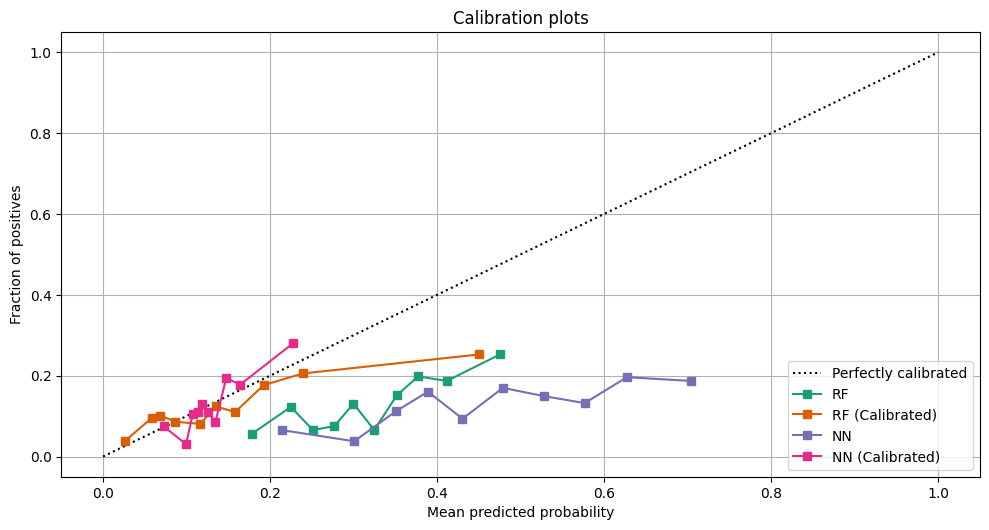

In [54]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

def mean_outcome_per_score(df, score_col, outcome_col):
    score_values = sorted(df[score_col].unique())
    mean_outcomes = []

    for score in score_values:
        mean_outcome = df[df[score_col] == score][outcome_col].mean()
        mean_outcomes.append(mean_outcome)

    return score_values, mean_outcomes

clf_list = [
    (clf, "RF"),
    (clf_isotonic, "RF (Calibrated)"),
    (pipeline_nn, "NN"),
    (clf_nn_isotonic, "NN (Calibrated)")
]
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(2, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[0, :])
calibration_displays = {}
for i, (clf_, name) in enumerate(clf_list):
    display = CalibrationDisplay.from_estimator(
        clf_,
        X_test if name != "Logistic" else X_test_lr_scaled,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i), strategy='quantile'
    )
    calibration_displays[name] = display

score_values, mean_outcomes = mean_outcome_per_score(pd.concat([X_hot['score'], y_hot], axis=1), 'score', 'out_bled_in_2yr')

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

plt.tight_layout()
plt.show()

## ROC Curves

### Uncalibrated

/rds/general/user/dba22/home/anaconda3/envs/hda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


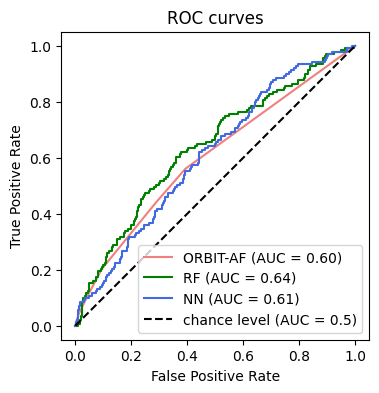

In [55]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay


fig, ax = plt.subplots(figsize=(4, 4))

RocCurveDisplay.from_predictions(
    pd.DataFrame(y_hot),
    X_hot['score'],
    name=f"ORBIT-AF",
    color="lightcoral",
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test,
    clf.predict_proba(X_test)[:,1],
    name=f"RF",
    color="green",
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test,
    pipeline_nn.predict_proba(X_test)[:,1],
    name=f"NN",
    color="royalblue",
    ax=ax
)



plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

### Calibrated

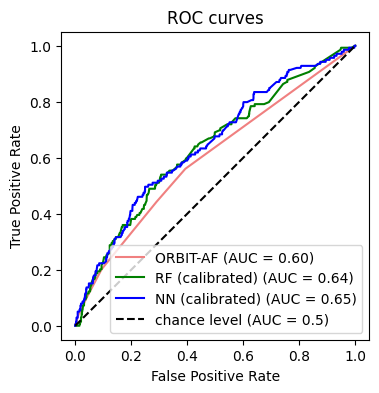

In [57]:
fig, ax = plt.subplots(figsize=(4, 4))

RocCurveDisplay.from_predictions(
    pd.DataFrame(y_hot),
    X_hot['score'],
    name=f"ORBIT-AF",
    color="lightcoral",
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test,
    clf_isotonic.predict_proba(X_test)[:,1],
    name=f"RF (calibrated)",
    color="green",
    ax=ax
)

RocCurveDisplay.from_predictions(
    y_test,
    clf_nn_isotonic.predict_proba(X_test)[:,1],
    name=f"NN (calibrated)",
    color="blue",
    ax=ax
)



plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curves")
plt.legend()
plt.show()

# Clustering

In [274]:
# Create a dummy dataset
continuous_features = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 46, 47, 48]
categorical_features = [25, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
                       49, 50, 51, 52, 53, 54, 55, 56]

XY_imputed_onehot_noout_typed = X
XY_imputed_onehot_noout_typed.iloc[:,continuous_features] = XY_imputed_onehot_noout_typed.iloc[:,continuous_features].apply(pd.to_numeric, errors='coerce')
for col in categorical_features:
    XY_imputed_onehot_noout_typed.iloc[:,col] = pd.Categorical(XY_imputed_onehot_noout_typed.iloc[:,col])

## K-medoids

In [277]:
import pandas as pd
import numpy as np
import gower
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import umap

df = XY_imputed_onehot_noout_typed
#df = subset
categorical_columns = df.select_dtypes(include=['category']).columns

# Convert categorical columns to object dtype
df[categorical_columns] = df[categorical_columns].astype('object')

# Scale the continuous features
numeric_features = df.select_dtypes(include=[np.number])
scaled_numeric_features = StandardScaler().fit_transform(numeric_features)

# Replace the original numeric features with the scaled version
df.loc[:, numeric_features.columns] = scaled_numeric_features

# Compute Gower distance matrix
gower_distance_matrix = gower.gower_matrix(df)

### Silhouette score

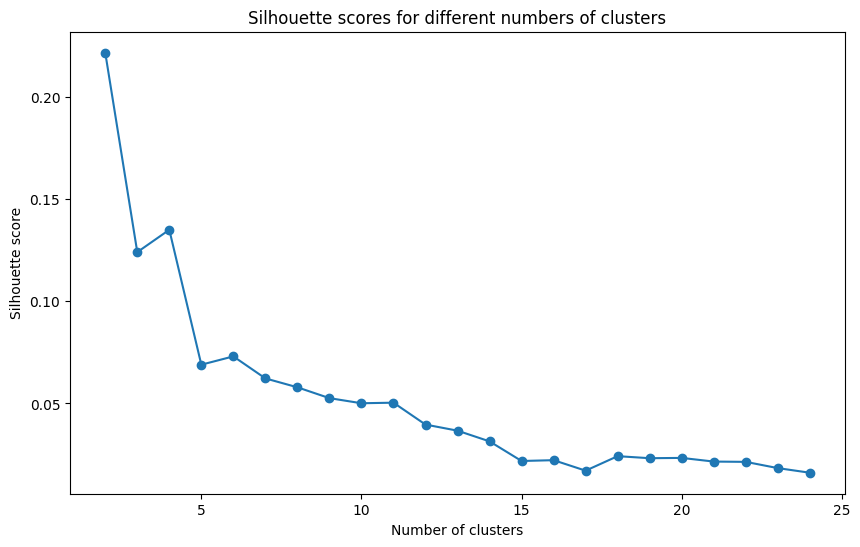

In [78]:
from sklearn.metrics import silhouette_score

# Create an empty list to store the silhouette scores
silhouette_scores = []
#distArray = ssd.squareform(gower_distance_matrix) 

# Define the range of cluster numbers to test
cluster_range = range(2, 25)  # Change this range as needed
np.fill_diagonal(gower_distance_matrix, 0)

# Iterate over the range of cluster numbers
for n_clusters in cluster_range:
    k_medoids = KMedoids(n_clusters=n_clusters, metric='precomputed', random_state=42)
    k_medoids_labels = k_medoids.fit_predict(gower_distance_matrix)
    
    # Calculate the silhouette score for the current configuration
    silhouette_avg = silhouette_score(gower_distance_matrix, k_medoids_labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.title('Silhouette scores for different numbers of clusters')
plt.show()


### Elbow method (WCSS)

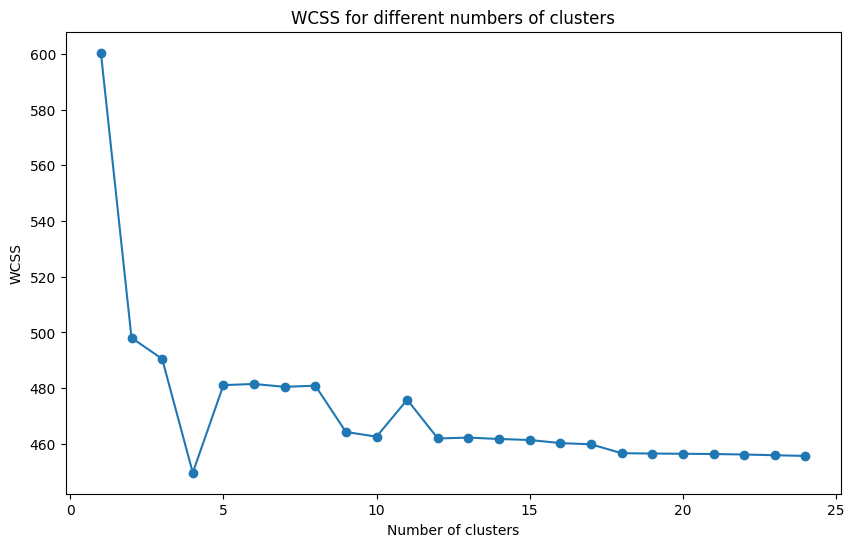

In [79]:
wcss = []
cluster_range = range(1, 25)

for i in cluster_range:
    k_medoids = KMedoids(n_clusters=i, metric='precomputed', random_state=42)
    k_medoids.fit(gower_distance_matrix)
    wcss.append(k_medoids.inertia_)

# Plot the WCSS against the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('WCSS for different numbers of clusters')
plt.show()


In [278]:
# Apply K-Medoids clustergower_distance_matrixing
k_medoids = KMedoids(n_clusters=2, metric='precomputed', random_state=42)  # Adjust the number of clusters using n_clusters
k_medoids_labels = k_medoids.fit_predict(gower_distance_matrix)

# Add cluster labels to the dataframe
df['cluster'] = k_medoids_labels

### t-SNE Visualisation

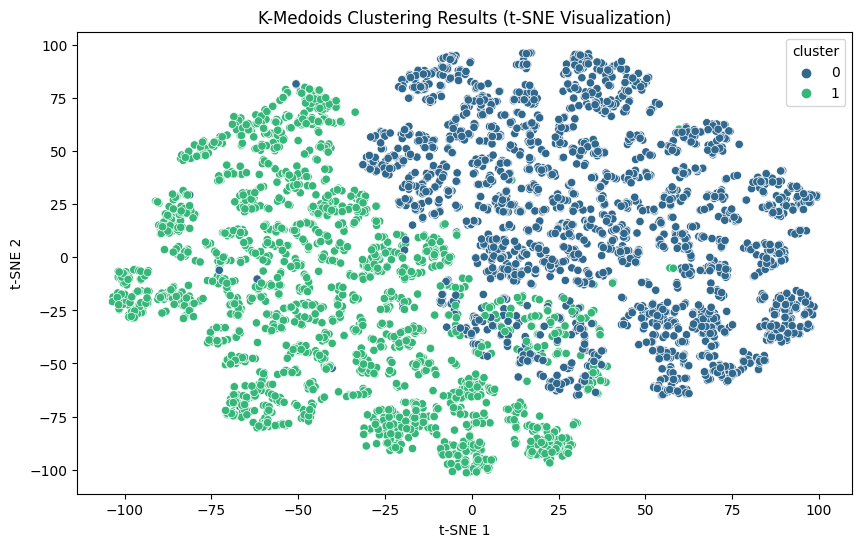

In [279]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, metric='precomputed', perplexity=5, random_state=42)
tsne_coordinates = tsne.fit_transform(gower_distance_matrix)

# Plot the t-SNE results with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_coordinates[:, 0], y=tsne_coordinates[:, 1], hue=df['cluster'], palette='viridis', legend='full')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('K-Medoids Clustering Results (t-SNE Visualization)')
plt.show()

### K-Prototypes

In [332]:
def collapse_one_hot(df, prefix):
    one_hot_columns = [col for col in df.columns if col.startswith(prefix)]
    numeric_one_hot = df[one_hot_columns].astype(int)
    collapsed_column = numeric_one_hot.idxmax(axis=1).str.replace(prefix, '')
    return collapsed_column

X_orig = X.drop(columns=['cluster'])
X_orig['ethnicity'] = collapse_one_hot(X_orig, 'ethnicity.')
X_orig['smoking'] = collapse_one_hot(X_orig, 'smoking.')

# Drop the original one-hot encoded columns
X_collapsed = X_orig.drop(columns=['ethnicity.asian', 'ethnicity.black', 'ethnicity.mixed', 'ethnicity.other', 'ethnicity.white',
                                   'smoking.never', 'smoking.previous', 'smoking.current'])

X_clust = X
categorical_columns = df.select_dtypes(include=['category']).columns

# Convert categorical columns to object dtype
df[categorical_columns] = df[categorical_columns].astype('object')

X_clust['ethnicity'] = collapse_one_hot(X_clust, 'ethnicity.')
X_clust['smoking'] = collapse_one_hot(X_clust, 'smoking.')

# Drop the original one-hot encoded columns
X_clust = X_clust.drop(columns=['ethnicity.asian', 'ethnicity.black', 'ethnicity.mixed', 'ethnicity.other', 'ethnicity.white',
                                   'smoking.never', 'smoking.previous', 'smoking.current'])

In [293]:
from kmodes.kprototypes import KPrototypes

catcol_idx = [X_collapsed.columns.get_loc(col) for col in list(X_collapsed.select_dtypes("object").columns)]

kproto = KPrototypes(n_clusters=2, init='Cao', 
                     n_jobs = 7, verbose=0, 
                     random_state=42)

clusters = kproto.fit_predict(X_collapsed, categorical=catcol_idx)

In [336]:
import pandas as pd
import numpy as np

df['cluster'] = clusters

# Merge the 'cluster' column from 'df' to 'XY_imputed_onehot_noout_typed_collapsed'
merged_df1 = pd.concat([X_clust, df['cluster']], axis=1)

# Group the data by the 'cluster' column
grouped_df1 = merged_df1.groupby('cluster')

# Calculate the mean for numerical columns separately for each cluster
mean_values = grouped_df1.apply(lambda g: g.select_dtypes(include=[np.number]).mean())

# Calculate the mode for 'object' columns separately for each cluster
mode_values = grouped_df1.apply(lambda g: g.select_dtypes(include=['object']).mode().iloc[0])

# Set display options for floats to show more decimals
pd.set_option('display.float_format', '{:.10f}'.format)

#print("Mean values for each cluster:")
pd.set_option('display.max_columns', None)
(mean_values)

,be_alcohol_freq.0.0,be_physact_walks.0.0,be_smok_packyears.0.0,bio_alb.0.0,bio_alp.0.0,bio_alt.0.0,bio_ast.0.0,bio_bas.0.0,bio_chol.0.0,bio_cr.0.0,bio_eos.0.0,bio_ggt.0.0,bio_hb.0.0,bio_hba1c.0.0,bio_hct.0.0,bio_lymph.0.0,bio_mon.0.0,bio_neutr.0.0,bio_plt.0.0,bio_ret.0.0,bio_tg.0.0,bio_urate.0.0,bio_urea.0.0,bio_vitd.0.0,bl_age.0.0,bl_sex.0.0,bmi.0.0,comorb_falls_lastyear.0.0,se_depr.0.0,antiplatelets,benzos,nsaids,ocs,ppi,ssri,stjohns,chf,copd,htn,liverdis,anaemia,cancer,vte,t2dm,vascdis,majbleed_prev,se_highest_quali,bp_sys_avg,bp_dia_avg,cluster
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.6306626243,55.6810298211,22.4676538767,44.5870784095,90.7114381710,30.0743128032,31.8896238569,0.0388279920,5.0884215785,85.6732242545,0.1955529225,68.8778926441,15.1090237773,41.4815383698,43.8698995626,2.0626380915,0.6175132406,5.1093295030,227.3430564612,0.0797881233,2.4708505527,398.8971276342,6.2923752684,43.9067777336,62.0202783300,0.8314115308,31.7418408795,1.3511888668,-0.7174029978,0.1029821074,0.0131212724,0.1280318091,0.0190854871,0.1900596421,0.0385685885,0.0000000000,0.0003976143,0.0512922465,0.4103379722,0.0031809145,0.0497017893,0.0652087475,0.1729622266,0.1693836978,0.2743538767,0.1725646123,3.9596063618,141.3904174950,86.1016640159,0.0000000000
1,2.2948197654,57.2466654817,11.6104882688,44.0933906150,86.0154870245,21.5684364735,27.8347092073,0.0312992179,5.1929091006,79.8647554213,0.1593032350,40.2738414504,13.9095865624,37.5111901884,40.4936146107,1.7543801635,0.4980696410,4.2018753644,232.5356363313,0.0558196694,1.5753426840,326.7758492712,6.0061084252,51.3266462851,61.7010309278,0.5638108781,27.6882102158,1.3855207963,-1.1916848931,0.0753643797,0.0117312478,0.0942054746,0.0231070032,0.1855670103,0.0554568077,0.0003554924,0.0017774618,0.0248844650,0.2836829008,0.0074653395,0.0853181657,0.0796302879,0.2232492001,0.0714539637,0.1972982581,0.1930323498,4.3549377888,133.2346445076,78.7778937078,1.0000000000


In [297]:
import pyreadr
import pandas as pd

pyreadr.write_rds("X_collapsed.Rds", X_collapsed)

In [339]:
pyreadr.write_rds("df.Rds", df)

#### Cluster interpretation

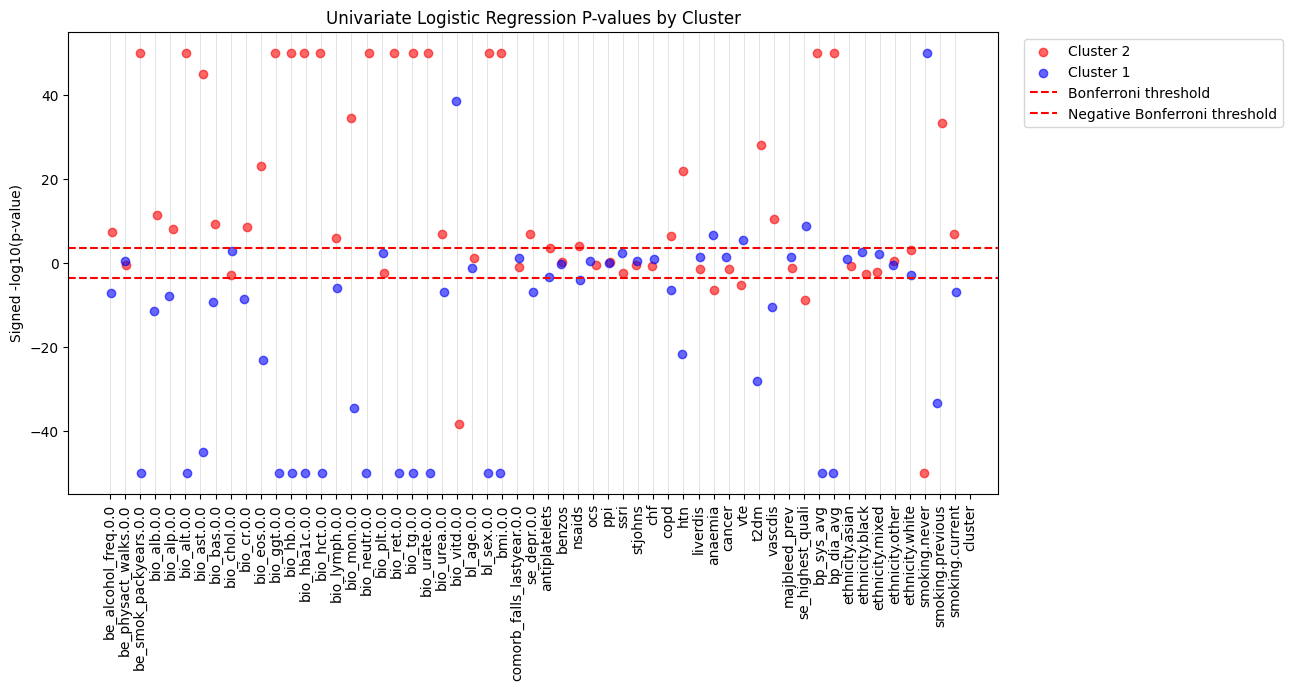

In [354]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression

X_orig = df
SMALL_CONSTANT = 1e-50
ALPHA = 0.05
NUM_TESTS = (len(X_orig.columns) - 1)*3  # Subtract 1 to exclude the 'cluster' column

bonferroni_threshold = -np.log10(ALPHA / NUM_TESTS)

# Get unique cluster numbers
unique_clusters = X_orig['cluster'].unique()

# Initialize an empty dictionary to store p-values
p_values = {}
coeff_signs = {}

# Perform univariate logistic regressions
for cluster in unique_clusters:
    # Create binary outcome variable for the current cluster
    binary_outcome = (X_orig['cluster'] == cluster).astype(int)

    for predictor in X_orig.columns:
        if predictor != 'cluster':
            # Fit logistic regression and get the coefficient sign
            lr = LogisticRegression().fit(X_orig[[predictor]], binary_outcome)
            coeff_sign = np.sign(lr.coef_[0][0])
            coeff_signs[(predictor, cluster)] = coeff_sign

            # Get p-value and adjust for the coefficient sign
            scores, pvalues = f_regression(X_orig[[predictor]], binary_outcome)
            p_values[(predictor, cluster)] = -np.log10(pvalues + SMALL_CONSTANT) * coeff_sign

# Prepare data for plotting
plot_data = pd.DataFrame([(predictor, cluster, p_value) for (predictor, cluster), p_value in p_values.items()],
                         columns=['predictor', 'cluster', 'signed -log10(p-value)'])

# Jitter settings
jitter_width = 0.2

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))
colors = {2: 'red', 1: 'blue'}

for cluster in unique_clusters:
    cluster_data = plot_data[plot_data['cluster'] == cluster].copy()
    cluster_data['predictor_index'] = cluster_data['predictor'].apply(lambda x: list(X_orig.columns).index(x))
    
    # Create jitter separately for each cluster
    jitter = np.random.uniform(-jitter_width, jitter_width, cluster_data.shape[0])
    cluster_data['predictor_jittered'] = cluster_data['predictor_index'] + jitter
    ax.scatter(cluster_data['predictor_jittered'], cluster_data['signed -log10(p-value)'], label=f'Cluster {cluster}', alpha=0.6, color=colors[cluster])

for i, predictor in enumerate(X_orig.columns):
    if predictor != 'cluster':
        ax.axvline(x=i, color='gray', linestyle='-', linewidth=0.5, alpha=0.3)    

ax.axhline(y=bonferroni_threshold, color='red', linestyle='--', label=f'Bonferroni threshold')
ax.axhline(y=-bonferroni_threshold, color='red', linestyle='--', label=f'Negative Bonferroni threshold')
#ax.set_xlabel('Predictors')
ax.set_ylabel('Signed -log10(p-value)')
ax.set_title('Univariate Logistic Regression P-values by Cluster')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

# Display the plot
plt.xticks(np.arange(len(X_orig.columns)), X_orig.columns, rotation=90)
plt.show()
